In [69]:
import numpy as np
import matplotlib.pyplot as plt
from math import erfc, sqrt
%matplotlib inline

# Parameters

In [70]:
#simulation parameters
n=10                       #number of bits used in the simulation (bitstream length)
step=0.05                  #simulation time step (one pulse of duration 1 has 20 samples)
t=np.arange(0,n,step)

In [71]:
#signal parameters
sigma_noise = 0.1            # relates to the channel noise.
filter_num = 1               # decides which of the 3 filters is being used in the receiver.

# Transmitter
Involves a binary source generating random 0s and 1s and a pulse shape filter that fits pulses on the bitstream.

In [72]:
def BinarySource(n):
	return np.random.randint(0,2,n)

In [73]:
def binarycode_to_signal(bitstream, step):
    T = 1  # assume the pulse period is 1
    A = 1  # assume the amplitude is 1
    pulse = np.ones(int(T/step))
    pulse = pulse*A
    signal = np.zeros(len(bitstream)*len(pulse))
    # Polar nonreturn to zero
    for i in range(len(bitstream)):
        if bitstream[i] == 1:
            signal[i*len(pulse):(i+1)*len(pulse)] = 1*pulse    # take the shape of pulse along the symbol's interval
        else:
            signal[i*len(pulse):(i+1)*len(pulse)] = -1*pulse
    return signal


# Channel
Only adds additive white Gaussian noise on the signal

In [74]:
def AWGN(n, sigma):
	return np.random.normal(0,sigma,n)

# Receiver
Receive signal from the channel then pass it by receive felter, sampler and decision maker.

In [75]:
def receive_filter(signal_noise,filter_num):
   filter_num-=1
   filters = [np.ones(int(1/step)), np.ones(1), np.sqrt(3)*np.arange(0, 1, step)]
   filter = filters[filter_num]
   filter = np.concatenate((filter, np.zeros(int(1/step)-len(filter))))       # zero padding for convolution.
   signal_noise_filter=np.convolve(signal_noise,filter)
   if (filter_num==0 or filter_num==2):
      signal_noise_filter=signal_noise_filter*step
   return signal_noise_filter



In [76]:
def sampler(sampling_period, signal_noise_filtered):
   samples = np.zeros(n)
   for i in range(len(samples)):
      samples[i] = signal_noise_filtered[sampling_period-1+i*sampling_period]
   return samples

In [77]:
Q = lambda x : 0.5 * erfc(x/sqrt(2))
def decision_maker(samples, λ):
   return (samples>λ)*1

# Simulation
simple simulation (only 10 bits) to illustrate how our approach works.

In [78]:
#generate the binary symbols
bitstream = BinarySource(n)
print("Bitstream: ",bitstream)

Bitstream:  [1 0 1 0 1 1 0 0 0 0]


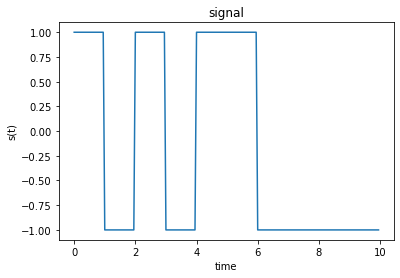

In [79]:
#generate the binary signal
signal=binarycode_to_signal(bitstream,step)
plt.plot(t,signal)
plt.xlabel('time')
plt.ylabel('s(t)')
plt.title('signal')
plt.show()

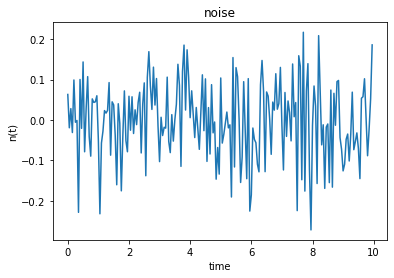

In [80]:
#generate the noise
noise=AWGN(len(signal),sigma_noise)

plt.plot(t,noise)
plt.xlabel('time')
plt.ylabel('n(t)')
plt.title('noise')
plt.show()

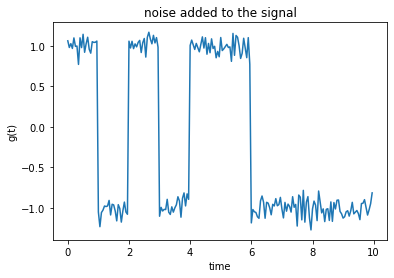

In [81]:
#add the noise to the signal
signal_noise=signal+noise
plt.plot(t,signal_noise)
plt.xlabel('time')
plt.ylabel('g(t)')
plt.title('noise added to the signal')
plt.show()

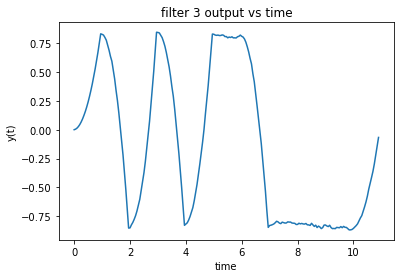

In [106]:
filter_num=3
signal_noise_filter=receive_filter(signal_noise, filter_num)
plt.plot(np.arange(0,len(signal_noise_filter)*step,step),signal_noise_filter)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.title('filter '+ str(filter_num) +' output vs time')
plt.savefig('filter_'+ str(filter_num) +'_output.jpg')

In [83]:
#sample the filtered signal
sampling_period = int(1/step)
samples = sampler(sampling_period, signal_noise_filter)

In [84]:
#decode the samples
reconstructed_bitstram = decision_maker(samples, 0)
print('Reconstructed Bitstram:',reconstructed_bitstram)

Reconstructed Bitstram: [1 0 1 0 1 1 0 0 0 0]


In [85]:
#results
print("Total number of bits:", len(bitstream))
print("Resived Wrong:", np.sum(bitstream!=reconstructed_bitstram))
print("BER:", np.sum(bitstream!=reconstructed_bitstram)/len(bitstream))

Total number of bits: 10
Resived Wrong: 0
BER: 0.0
